## теория

Задача классификации токенов (NER - извлечению сущностей из документов): в данном тексте нужно классифицировать токены по пренадлежности к классу (в данном случае: O, PER, ORG, LOC, EVT, PRO).

Классичесские методы:

- правила(например регулярки), имеют плохую обобщаемость, но быстро работают с минимальными затратами ресурсов
- классичесская задача классификации (например с помощью логистической регресии, бустингов etc.), может не опираться на контекст (если не использовать контекстные фичи, например по 5 токенов до и после обрабатываемого токена), всё ещё быстрее и дешевле ANN и LLM, может быть недостаточно точным 
- DL
  - рекурентные архитектуры, для учитывания порядка слов + дополнительные фичи
  - Transformers: классический подход без LLM, например на основе BERT и его модификаций (ruBERT, SBERT etc.)
- LLM (об этом ниже)

Решение через LLM:

1. Просто написать в промпте задание и текст с которым работать
2. Промпт-инжиниринг
   - Добавление одного или нескольких примеров
   - Подбор промпта
   - Написать порядок действий
   - струтурирование промпта
3. Добавление Reasoning (например CoT)
4. Finetuning (дорого)
5. Использование внешних ресурсов (RAG, MCP etc.)

Оценка качества (основные):

- Precision: TP / (TP + FP)
- Recall: TP / (TP + FN)
- F1: 2 TP / (2 TP + FP + FN)
- micro-F1 (по всем сущностям вместе) и macro-F1 (среднее по классам)


In [1]:
# чтение данных
import os
import re
import pandas as pd

raw_dir = "../data/sample_pl_cs_ru_bg/raw/ru"
ann_dir = "../data/sample_pl_cs_ru_bg/annotated/ru"

file_pat = re.compile(r'^brexit_ru\.txt_file_(\d+)\.txt$')

rows = []

for fname in os.listdir(raw_dir):
    m = file_pat.match(fname)
    if not m:
        continue
    doc_num = m.group(1)
    raw_path = os.path.join(raw_dir, fname)

    with open(raw_path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()

    if not lines:
        continue

    document_id = lines[0].strip()
    document_text = "\n".join(lines[4:]).strip()

    ann_name = f"brexit_ru.txt_file_{doc_num}.out"
    ann_path = os.path.join(ann_dir, ann_name)

    if not os.path.exists(ann_path):
        rows.append([document_id, document_text, None, None])
        continue

    with open(ann_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                continue
            if "\t" not in line:
                continue

            parts = line.split("\t")
            if len(parts) < 4:
                continue

            surface = parts[0].strip()
            ent_type = parts[2].strip()

            rows.append([document_id, document_text, surface, ent_type])

df = pd.DataFrame(rows, columns=["document_id", "document_text", "entity", "gold_answer"])

# шапка
# print(df.columns) # название столбцов, можно также назвать "шапкой датафрейма"
print(df.head())
print(df.shape)

  document_id                                      document_text  \
0       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
1       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
2       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
3       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   
4       ru-10  Тереза Мэй рассчитывает усидеть в седле до зав...   

          entity gold_answer  
0         Brexit         EVT  
1       Альбиона         LOC  
2       Альбионе         LOC  
3  Борис Джонсон         PER  
4       Британии         LOC  
(153, 4)


In [ ]:
# Формирование промпта
# другие варианты промпта находятся в файле PROMPT.py
prompt_v6 = '''<PROCEDURE>
1. Прочитай весь текст целиком.
2. Найди абсолютно все упоминания сущностей (без выдумывания).
3. Определи их тип согласно категориям:
   - PER: персоны (имена людей, фамилии, должностные лица)
   - ORG: организации (компании, учреждения, партии, СМИ)
   - LOC: локации (страны, города, регионы, географические объекты)
   - EVT: события (конференции, саммиты, войны, выборы)
   - PRO: проекты и программы (названия проектов, программ, инициатив)
4. Верни результат ТОЛЬКО в виде валидного JSON без дополнительного текста.
</PROCEDURE>

<FORMAT>
Результат должен быть строго в следующем JSON формате:
{
  "fields": ["PER", "ORG", "LOC", "EVT", "PRO"],
  "values": [
    ["список_персон"],
    ["список_организаций"], 
    ["список_локаций"],
    ["список_событий"],
    ["список_проектов"]
  ]
}
</FORMAT>

<EXAMPLES>
<example_text>
Премьер-министр Польши Матеуш Моравецкий считает, что проект "Северный поток-2" представляет пример непоследовательности Европейского союза. 
Об этом сообщает РБК-Украина со ссылкой на интервью каналу CNBC. Моравецкий напомнил, что Европейской комиссией была заблокирована реализация 
проекта "Южный поток". Министр иностранных дел Польши Яцек Чапутович заявил, что строительство угрожает безопасности Украины.
Президент Польши Анджей Дуда заявил о необходимости санкций против России.
</example_text>

<example_output>
{
  "fields": ["PER", "ORG", "LOC", "EVT", "PRO"],
  "values": [
    ["Матеуш Моравецкий", "Моравецкий", "Яцек Чапутович", "Анджей Дуда"],
    ["Европейского союза", "РБК-Украина", "CNBC", "Европейской комиссией"],
    ["Польши", "Украины", "России"],
    [],
    ["Северный поток-2", "Южный поток"]
  ]
}
</example_output>
</examples>

<RULES>
- Возвращай ТОЛЬКО JSON, никакого дополнительного текста
- Все строки в JSON должны быть в двойных кавычках
- Если для категории нет сущностей, используй пустой массив []
- Сущности записывай точно как в тексте, без изменений
- Одну и ту же сущность можно записывать в рамках одной категории, если она упоминается несколько раз в тексте
- Не добавляй несуществующие в тексте сущности
</RULES>
'''

def build_prompt_targeted(row):
    text = str(row["document_text"]).strip()
    text_formated_for_prompt = f"<text>\n```\n{text}\n```\n</text>"
    doc_id = str(row["document_id"]).strip()
    doc_id_formated_for_prompt = f"\n<text_id>\n```\n{doc_id}\n```\n</text_id>"    
    return prompt_v6 + text_formated_for_prompt + doc_id_formated_for_prompt


In [154]:
#общение с GigaChat

import os
import json
from typing import List, Any, Dict
from dotenv import load_dotenv
from gigachat import GigaChat
from gigachat.models import Chat, Function, FunctionParameters, Messages, MessagesRole

load_dotenv("../.env")
auth_key = os.getenv("GIGACHAT_CREDENTIALS")

def add_json_elements(json_data: str, fields: List[str], values: List[Any]) -> str:
    try:
        data = json.loads(json_data) if json_data and json_data.strip() else {}
        for field, value in zip(fields, values):
            if isinstance(value, str):
                try:
                    value = json.loads(value)
                except json.JSONDecodeError:
                    pass
            data[field] = value
        return json.dumps(data, ensure_ascii=False, indent=2)
    except Exception as e:
        return json.dumps({"error": f"{type(e).__name__}: {e}"}, ensure_ascii=False)

add_json_function = Function(
    name="add_json_elements",
    description="Собери сущности по типам (PER/ORG/LOC/EVT/PRO) и запиши массивы строк в JSON-объект.",
    parameters=FunctionParameters(
        type="object",
        properties={
            "json_data": {
                "type": "string", 
                "description": "Исходный JSON ('{}' для создания с нуля)"
            },
            "fields": {
                "type": "array", 
                "items": {"type": "string"}, 
                "description": "Напр.: ['PER','ORG','LOC','EVT','PRO']"
            },
            "values": {
                "type": "array", 
                "description": "Массивы строк для каждого поля"
            }
        },
        required=["json_data", "fields", "values"],
    ),
)

_ROLE_MAP = {
    "system": MessagesRole.SYSTEM,
    "user": MessagesRole.USER,
    "assistant": MessagesRole.ASSISTANT,
}

def _to_messages(objs: List[Dict[str, str]]) -> List[Messages]:
    msgs = []
    for m in objs:
        role_key = m.get("role", "user").lower()
        role = _ROLE_MAP.get(role_key, MessagesRole.USER)
        msgs.append(Messages(role=role, content=m.get("content", "")))
    return msgs


In [155]:
def gigachat_generate_simple(messages_list, *, temperature=0.7, max_tokens=256):
    payload = Chat(
        messages=_to_messages(messages_list),
        temperature=temperature,
        max_tokens=max_tokens,
    )
    with GigaChat(credentials=auth_key, model="GigaChat-2", verify_ssl_certs=False) as giga:
        return giga.chat(payload)

In [159]:
def gigachat_generate_fc(messages_list, *, temperature=0.5, max_tokens=1200):
    """
    Делает один запрос к GigaChat с объявленной функцией add_json_elements.
    Если модель вызывает функцию — исполняем её локально и возвращаем готовый JSON иначе сырой ответ.
    """
    payload = Chat(
        messages=_to_messages(messages_list),
        temperature=temperature,
        max_tokens=max_tokens,
        functions=[add_json_function],
        function_call="auto",
    )

    with GigaChat(credentials=auth_key, model="GigaChat-2-Pro", verify_ssl_certs=False) as giga:
        resp = giga.chat(payload)
    
    choice = resp.choices[0]
    msg = choice.message

    func_name, func_args = None, None
    if getattr(msg, "function_call", None):
        func_name = getattr(msg.function_call, "name", None)
        func_args = getattr(msg.function_call, "arguments", None)
    elif getattr(msg, "tool_calls", None):
        tool = msg.tool_calls[0]
        inner = getattr(tool, "function", None)
        if inner:
            func_name = getattr(inner, "name", None)
            func_args = getattr(inner, "arguments", None)

    # если функция не вызвана — вернём обычный текст
    if not func_name:
        return {"json": "", "text": msg.content, "raw": resp, "note": "function_call не был использован"}

    # локально исполняем add_json_elements
    args = json.loads(func_args) if isinstance(func_args, str) else (func_args or {})
    result_json = add_json_elements(
        json_data=args.get("json_data", "{}"),
        fields=args.get("fields", []),
        values=args.get("values", []),
    )
    return {"json": result_json, "raw": resp}

In [160]:
from pprint import pprint

ans = {}

# выбираем уникальные документы
unique_docs = df[~df.duplicated(subset=['document_id'])]

for _, row in unique_docs.iterrows():
    doc_id = row["document_id"]
    prompt = build_prompt_targeted(row)

    messages_fc = [
        {"role": "system", "content": prompt},
        {"role": "assistant", "content": "```json"} #т.к. плохо использует функции, лучще уж будет использовать форматный вывод
    ]

    res_fc = gigachat_generate_fc(messages_fc)

    if res_fc.get("json"):
        ans[doc_id] = res_fc["json"]
    else:
        # обрезаем markdown-код-блок, если модель вернула как ```json ... ```
        text = res_fc.get("text", "")
        if "```" in text:
            text = text.split("```")[0]  # берём содержимое до ```, т.к. модель начинает генерировать с ```json в истории чата
        ans[doc_id] = text.strip()

pprint(ans) #вывод полученного ответа от LLM в красивом формате


{'ru-10': '{\n'
          '  "fields": ["PER", "ORG", "LOC", "EVT", "PRO"],\n'
          '  "values": [\n'
          '    ["Тереза Мэй", "Борис Джонсон", "Мишель Барнье", "Себастьян '
          'Курц"],\n'
          '    ["партия тори", "Евросоюз", "Международный валютный фонд", '
          '"Еврокомиссия"],\n'
          '    ["Британии", "Великобритании", "Лондон", "Брюссель", "Альбион", '
          '"Австрия", "Европа", "Северная Ирландия", "Ла-Манш"],\n'
          '    ["Brexit", "конференция партии тори", "экстренный саммит '
          'Евросоюза"],\n'
          '    []\n'
          '  ]\n'
          '}',
 'ru-1000': '{\n'
            '  "fields": ["PER", "ORG", "LOC", "EVT", "PRO"],\n'
            '  "values": [\n'
            '    ["Борис Джонсон", "Дэвид Дэвис", "Стив Бейкер", "Тереза '
            'Мэй"],\n'
            '    ["The Guardian", "УНН", "британский парламент"],\n'
            '    ["Великобритании", "Соединенного Королевства", "ЕС"],\n'
            '    [],\n'
     

In [166]:
def create_dataframe(data):
    rows = []
    
    for doc_id, json_str in data.items():
        try:
            # Парсим JSON
            doc_data = json.loads(json_str)
        except json.JSONDecodeError as e:
            print(f"Ошибка парсинга JSON для документа {doc_id}: {e}")
            continue
        
        fields = doc_data['fields']  # ['PER', 'ORG', 'LOC', 'EVT', 'PRO']
        values = doc_data['values']  # список списков для каждого типа
        
        # Проходим по каждому типу сущности
        for field_idx, field_type in enumerate(fields):
            if field_idx < len(values):
                entities_list = values[field_idx]
                
                # Проходим по каждой сущности в этом типе
                for entity_name in entities_list:
                    rows.append({
                        'document_id': doc_id,
                        'entity': entity_name.strip(),
                        'ans': field_type
                    })
    
    return pd.DataFrame(rows)

In [ ]:
# Создаем DataFrame
df_pred = create_dataframe(ans)

print("Размер DataFrame:", df_pred.shape)
print("\nПервые 10 строк:")
print(df_pred.head(10))

print(f"\nВсего строк: {len(df_pred)}")
print(f"\nУникальные типы сущностей: {df_pred['ans'].unique()}")
print(f"\nКоличество сущностей по типам:")
print(df_pred['ans'].value_counts())

print(f"\nПримеры по документам:")
for doc_id in df_pred['document_id'].unique():
    doc_entities = df_pred[df_pred['document_id'] == doc_id]
    print(f"\n{doc_id}: {len(doc_entities)} сущностей")
    print(doc_entities.head(3).to_string(index=False))

Размер DataFrame: (94, 3)

Первые 10 строк:
  document_id                       entity  ans
0       ru-10                   Тереза Мэй  PER
1       ru-10                Борис Джонсон  PER
2       ru-10                Мишель Барнье  PER
3       ru-10               Себастьян Курц  PER
4       ru-10                  партия тори  ORG
5       ru-10                     Евросоюз  ORG
6       ru-10  Международный валютный фонд  ORG
7       ru-10                 Еврокомиссия  ORG
8       ru-10                     Британии  LOC
9       ru-10               Великобритании  LOC

Всего строк: 94

Уникальные типы сущностей: ['PER' 'ORG' 'LOC' 'EVT' 'PRO']

Количество сущностей по типам:
ans
LOC    32
PER    30
ORG    21
EVT     7
PRO     4
Name: count, dtype: int64

Примеры по документам:

ru-10: 20 сущностей
document_id        entity ans
      ru-10    Тереза Мэй PER
      ru-10 Борис Джонсон PER
      ru-10 Мишель Барнье PER

ru-1000: 10 сущностей
document_id        entity ans
    ru-1000 Борис Джо

In [ ]:
# Сохраним результаты
df.to_csv('../data/result.csv', encoding='utf-8', index=False)
df_pred.to_csv('../result/result.csv', encoding='utf-8', index=False)
with open("../result/result.json", 'w', encoding='utf-8') as f:
    json.dump(ans, f, ensure_ascii=False, indent=4)


In [215]:
# функции для подсчёта метрик
import re
import numpy as np
import pandas as pd

def _normalize(s: str) -> str:
    """
    Нормализация сущностей для оценки
    """
    if s is None:
        return ""
    s = str(s)
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def score_fn(gold: str, pred: str) -> float:
    """
    базовое сравнение
    """
    return float(_normalize(gold) == _normalize(pred))

def _prep_gold(df: pd.DataFrame) -> pd.DataFrame:
    assert {"document_id","entity","gold_answer"}.issubset(df.columns)
    g = df[["document_id","entity","gold_answer"]].copy()
    g["entity_norm"] = g["entity"].map(_normalize)
    g["type"] = g["gold_answer"].str.upper().str.strip()
    g["key"] = g["document_id"].astype(str) + "||" + g["entity_norm"] + "||" + g["type"]
    return g[["document_id","entity","entity_norm","type","key"]].drop_duplicates()

def _prep_pred(df_pred: pd.DataFrame) -> pd.DataFrame:
    assert {"document_id","entity","ans"}.issubset(df_pred.columns)
    p = df_pred[["document_id","entity","ans"]].copy()
    p["entity_norm"] = p["entity"].map(_normalize)
    p["type"] = p["ans"].str.upper().str.strip()
    p["key"] = p["document_id"].astype(str) + "||" + p["entity_norm"] + "||" + p["type"]
    return p[["document_id","entity","entity_norm","type","key"]].drop_duplicates()

def compute_metrics(df_gold: pd.DataFrame, df_pred: pd.DataFrame):
    """
    Возвращает:
      - micro precision/recall/F1
      - таблицы с агрегированием по type и по document_id
    """
    g = _prep_gold(df_gold)
    p = _prep_pred(df_pred)

    # TP: пересечение по ключу (doc, entity_norm, type)
    tp = pd.merge(g[["key"]], p[["key"]], on="key", how="inner").drop_duplicates()
    TP = len(tp)
    FP = len(p) - TP
    FN = len(g) - TP

    def safe_div(a, b):
        return (a / b) if b else 0.0

    precision = safe_div(TP, TP + FP)
    recall = safe_div(TP, TP + FN)
    f1 = safe_div(2 * precision * recall, precision + recall)

    micro = {"precision": precision, "recall": recall, "f1": f1, "tp": TP, "fp": FP, "fn": FN}

    # Агрегация по типу сущности для каждого типа считаем TP/FP/FN:
    tp_keys = set(tp["key"])
    g["is_tp"] = g["key"].isin(tp_keys)
    p["is_tp"] = p["key"].isin(tp_keys)

    agg_type = []
    for t in sorted(set(g["type"]).union(set(p["type"]))):
        g_t = g[g["type"] == t]
        p_t = p[p["type"] == t]
        TP_t = len(pd.merge(g_t[["key"]], p_t[["key"]], on="key", how="inner").drop_duplicates())
        FP_t = len(p_t) - TP_t
        FN_t = len(g_t) - TP_t
        prec_t = safe_div(TP_t, TP_t + FP_t)
        rec_t = safe_div(TP_t, TP_t + FN_t)
        f1_t = safe_div(2 * prec_t * rec_t, prec_t + rec_t)
        agg_type.append({"type": t, "tp": TP_t, "fp": FP_t, "fn": FN_t,
                         "precision": prec_t, "recall": rec_t, "f1": f1_t})
    df_by_type = pd.DataFrame(agg_type).sort_values("type").reset_index(drop=True)

    # Агрегация по документу
    agg_doc = []
    for d in sorted(set(g["document_id"]).union(set(p["document_id"]))):
        g_d = g[g["document_id"] == d]
        p_d = p[p["document_id"] == d]
        TP_d = len(pd.merge(g_d[["key"]], p_d[["key"]], on="key", how="inner").drop_duplicates())
        FP_d = len(p_d) - TP_d
        FN_d = len(g_d) - TP_d
        prec_d = safe_div(TP_d, TP_d + FP_d)
        rec_d  = safe_div(TP_d, TP_d + FN_d)
        f1_d   = safe_div(2 * prec_d * rec_d, prec_d + rec_d)
        agg_doc.append({"document_id": d, "tp": TP_d, "fp": FP_d, "fn": FN_d,
                        "precision": prec_d, "recall": rec_d, "f1": f1_d})
    df_by_doc = pd.DataFrame(agg_doc).sort_values("document_id").reset_index(drop=True)
    # return micro['f1'] # если нужна именно 1 метрика, например F1,
    return micro, df_by_type, df_by_doc


In [216]:
def _run_unit_tests():
    # --- score_fn: нормализация без транслита ---
    assert score_fn("Тереза Мэй", "тереза  мэй") == 1.0
    assert score_fn("Борис Джонсон", "Борис  Джонсон ") == 1.0
    assert score_fn("ЕС", "Ес") == 1.0
    assert score_fn("ЕС", "ЕЭС") == 0.0
    assert score_fn("", None) == 1.0

    # --- контрольная выборка ---
    df_gold_test = pd.DataFrame({
        "document_id": ["d1","d1","d1","d2","d2"],
        "entity": ["Тереза Мэй","ЕС","Лондон","Борис Джонсон","брексит"],
        "gold_answer": ["PER","ORG","LOC","PER","EVT"]
    })

    df_pred_test = pd.DataFrame({
        "document_id": ["d1","d1","d1","d2","d2","d2"],
        "entity": ["тереза  мэй","Ес","Париж","Борис Джонсон","брексит","что-то лишнее"],
        "ans": ["PER","ORG","LOC","PER","EVT","ORG"]
    })
    
    micro, by_type, by_doc = compute_metrics(df_gold_test, df_pred_test)
    assert micro["tp"] == 4 and micro["fp"] == 2 and micro["fn"] == 1

    exp_precision = 2/3
    exp_recall = 0.8
    exp_f1 = (2*exp_precision*exp_recall)/(exp_precision+exp_recall)
    assert abs(micro["precision"] - exp_precision) < 1e-9
    assert abs(micro["recall"] - exp_recall) < 1e-9
    assert abs(micro["f1"] - exp_f1) < 1e-9

    # доп. кейсы: дубликаты и неверный тип
    df_pred_dups = pd.DataFrame({
        "document_id": ["d1","d1","d1"],
        "entity": ["Тереза Мэй","Тереза   Мэй","ЕС"],
        "ans": ["PER","PER","LOC"]  # ЕС как LOC — не TP
    })
    micro2, *_ = compute_metrics(df_gold_test, df_pred_dups)
    # TP=1 (Тереза), FP=1 (ЕС как LOC), FN=4
    assert micro2["tp"] == 1 and micro2["fp"] == 2 and micro2["fn"] == 4

    return "✅ unit-tests passed"

print(_run_unit_tests())

✅ unit-tests passed


In [ ]:
micro, df_by_type, df_by_doc = compute_metrics(df, df_pred)
print("MICRO:", micro)
display(df_by_type)  
display(df_by_doc)  

MICRO: {'precision': 0.5425531914893617, 'recall': 0.33774834437086093, 'f1': 0.41632653061224484, 'tp': 51, 'fp': 43, 'fn': 100}


,type,tp,fp,fn,precision,recall,f1
0,EVT,3,4,10,0.428571,0.230769,0.300000
1,LOC,14,18,22,0.437500,0.388889,0.411765
2,ORG,10,11,25,0.476190,0.285714,0.357143
3,PER,24,6,38,0.800000,0.387097,0.521739
4,PRO,0,4,5,0.000000,0.000000,0.000000


,document_id,tp,fp,fn,precision,recall,f1
0,ru-10,9,11,35,0.450000,0.204545,0.281250
1,ru-1000,6,4,8,0.600000,0.428571,0.500000
2,ru-1001,6,2,7,0.750000,0.461538,0.571429
3,ru-1002,5,2,2,0.714286,0.714286,0.714286
4,ru-1003,4,4,6,0.500000,0.400000,0.444444
5,ru-1004,6,7,12,0.461538,0.333333,0.387097
6,ru-1006,6,3,7,0.666667,0.461538,0.545455
7,ru-1011,3,5,15,0.375000,0.166667,0.230769
8,ru-1017,6,5,8,0.545455,0.428571,0.480000


## Возможно ли ускорить вычисление функции через векторную реализацию?

Да. Вместо покомпонентных циклов можно использовать векторизацию в pandas/NumPy: 
сформировать ключи `(document_id, entity_norm, type)`, находить TP через `merge` или пересечение индексов, 
а FP и FN считать по размерам множеств. Такой подход работает линейно от числа строк, 
использует быстрые хэш-операции и groupby, поэтому существенно быстрее ручных циклов, но зачастую менее читаемо и неочевидно с первого взгляда.


## Почему такая метрика

Мы считаем после лёгкой нормализации регистра/пробелов:

* У нас нет координат слов в тексте, поэтому корректно проверять равенство строк сущности и совпадение класса
* Это максимально близко к принятой в NER практике (CoNLL): precision/recall/F1 на уровне сущностей с полным повторением границ и класса
* Простая нормализация снижает шум токенизации/регистра и не вносит субъективности
* Для отчётности удобно давать **micro-F1** (по всем сущностям) и разрезы по классам и документам

### Альтернативы и почему не они тут

* Token-level F1 / частичное пересечение спанов — нужны координаты/токенизация; усложняет пайплайн и интерпретацию.
* Fuzzy-match (дистанции, леммы) — даёт «мягкую» оценку, но добавляет спорных совпадений и сильно зависит от настроек/моделей морфологии.
* Relaxed match (например, пропуск кейсов «Британия» vs «Великобритания») — полезно для анализа ошибок, но для основного скоринга менее объективно.

Вывод: выбранная метрика — прозрачная, воспроизводимая, согласованная с датасетом и постановкой; векторная реализация через `merge`/`Index` обеспечивает высокую скорость и масштабируемость.


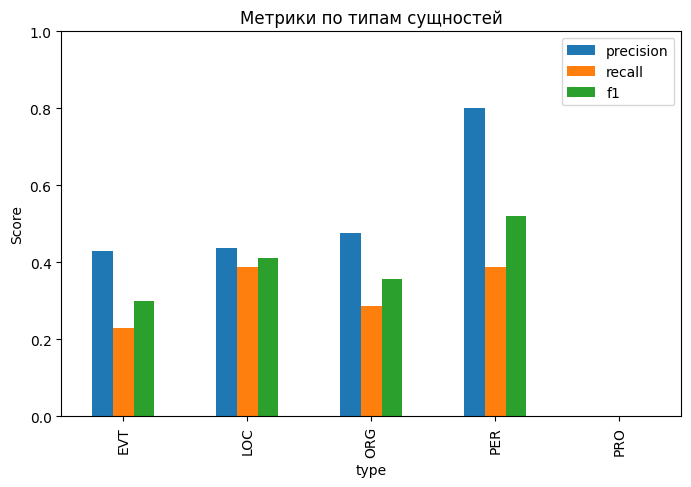

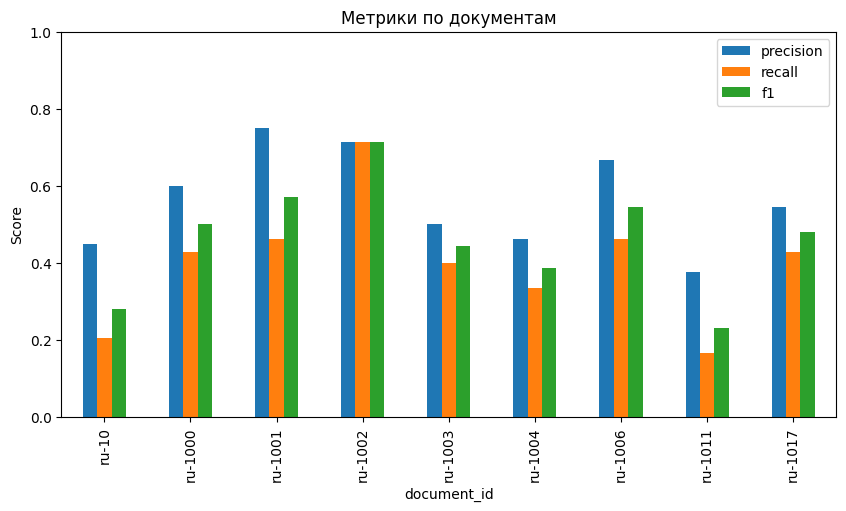

In [220]:
import matplotlib.pyplot as plt

df_by_type.set_index("type")[["precision","recall","f1"]].plot(kind="bar", figsize=(8,5))
plt.title("Метрики по типам сущностей")
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()

df_by_doc.set_index("document_id")[["precision","recall","f1"]].plot(kind="bar", figsize=(10,5))
plt.title("Метрики по документам")
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()

## Выводы

Общие (micro):

* precision \~0.54 → половина найденных сущностей верные
* recall \~0.34 → модель пропускает большую часть сущностей
* итоговый F1 \~0.42 — среднее качество

По классам:

* PER (персоны) извлекаются лучше всех: F1 ≈ 0.52, высокая precision (0.8), но много пропусков (recall \~0.39)
* LOC / ORG / EVT — средние показатели (F1 \~0.3–0.4). Ошибки часто связаны с путаницей между ними
* PRO (продукты) почти не извлекаются: F1=0.0 (модель игнорирует этот класс), но в данных их меньше всего

По документам:

Есть сильная вариативность:

* Лучшая работа на `ru-1002` (F1 ≈ 0.71).
* Слабее всего на длинных сложных текстах (`ru-1011`, F1 ≈ 0.23).

В целом precision обычно выше recall → модель чаще «угадывает правильно, но мало», чем «собирает всё».

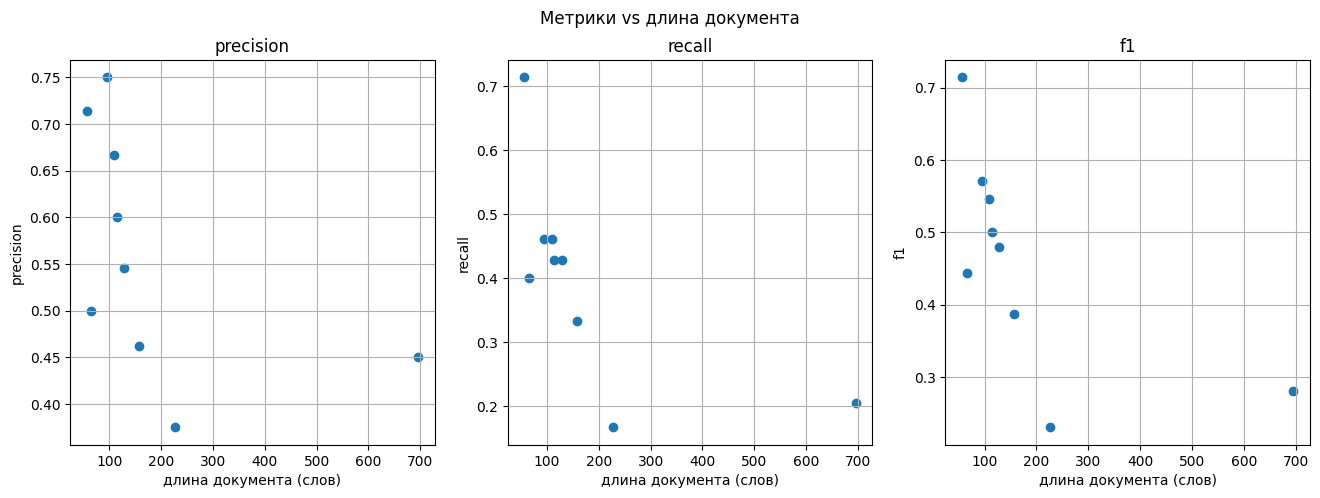

            doc_len  precision    recall        f1
doc_len    1.000000  -0.493128 -0.636430 -0.635893
precision -0.493128   1.000000  0.840972  0.921531
recall    -0.636430   0.840972  1.000000  0.983343
f1        -0.635893   0.921531  0.983343  1.000000


In [221]:
# Зависимость от длины текста

df_len = df.groupby("document_id")["document_text"].first().reset_index()
df_len["doc_len"] = df_len["document_text"].str.split().apply(len)

df_doc_metrics = df_by_doc.merge(df_len[["document_id","doc_len"]], on="document_id")


fig, axes = plt.subplots(1, 3, figsize=(16,5))
for ax, metric in zip(axes, ["precision","recall","f1"]):
    ax.scatter(df_doc_metrics["doc_len"], df_doc_metrics[metric])
    ax.set_title(metric)
    ax.set_xlabel("длина документа (слов)")
    ax.set_ylabel(metric)
    ax.grid(True)
plt.suptitle("Метрики vs длина документа")
plt.show()

print(df_doc_metrics[["doc_len","precision","recall","f1"]].corr())


## Выводы
1. Зависимость метрик от длины документа действительно есть, коэффициенты корреляции показывают отрицательную 
   связь между `doc_len` и всеми метриками: precision –0.49; recall: –0.64; f1: –0.64

2. Recall и F1 падают сильнее на коротких документах (до 100–150 слов) recall держится около 0.4–0.7,
    на длинных (200+ слов) падает до 0.2 и ниже. Модель чаще пропускает сущности, когда текст длинный.

3. Precision тоже снижается, но слабее: на коротких текстах достигает 0.7–0.75,
    на длинных (600–700 слов) опускается до \~0.45, то есть модель всё ещё «более-менее угадывает», но реже попадает в полное покрытие.

4. F1 закономерно следует за recall: лучший результат (\~0.7) на документе средней длины (\~100 слов),
    худший (\~0.2–0.3) на самых длинных документах.


### Когда модель отвечает правильно

Люди (PER): самая высокая точность (precision \~0.8), F1 \~0.52.Персоны обычно имеют уникальные и легко узнаваемые формы (имена, фамилии с заглавной буквы).

Короткие документы: для текстов длиной <100 слов F1 доходит до \~0.7, в коротких контекстах проще удерживать все сущности.

### Когда модель ошибается

События (EVT): F1 \~0.3, модель часто пропускает или путает с организациями/локациями.

Продукты (PRO): F1=0, класс практически игнорируется.

Локации и организации (LOC/ORG): F1 \~0.35–0.4, частая путаница: «Евросоюз» → иногда как ORG, иногда как LOC. «Брюссель» → может быть и город (LOC), и метонимия для Еврокомиссии (ORG).

Длинные документы (>200 слов): recall резко падает (до 0.2). Модель выхватывает только часть сущностей, игнорирует редкие или второстепенные.


### Причины ошибок

1. Длинные тексты, много сущностей, модель теряет часть.
2. Неоднозначность классов: LOC ↔ ORG, EVT ↔ действие.
3. Слабое покрытие редких классов (PRO/EVT) в примерах и промпте.


### Как повысить метрики

1. Улучшить промпт, опираясь на метрики: более жёстко требовать все типы сущностей; добавить больше few-shot примеров с PRO и EVT
   уточнить, как различать LOC vs ORG, EVT vs действие.

2. Разбивать длинные документы: разбивать на чанки по абзацам (например, по 100–150 слов), запускать LLM на каждом куске. 
   Собирать уникальные сущности на выходе.

3. Потенциально Пост-обработка: использовать словари/регулярки для дополнения типовых сущностей (страны, известные события);
   нормализовать регистр, склонения (*Борис Джонсон* ↔ *Бориса Джонсона*).

4. Гибридный подход: LLM для «умных» случаев + словари/NER-модель для устойчивого покрытия LOC/ORG.

5. Обучение/дообучение (если возможно), либо подсказки через RAG с внешними словарями (страны, организации).


## Выводы

В ходе работы я впервые полноценно попробовал GigaChat API: подключение, настройку запросов и работу с function calling. Столкнулся с ограничениями вроде отсутствия StopSequence и форматного вывода, поэтому пришлось придумывать обходные решения и обрабатывать ответы вручную — это дало практику в том, как «обвязывать» LLM в реальных задачах.

Полезным опытом стало и написание промптов: я пробовал разные форматы инструкций, добавлял примеры и добивался более стабильного извлечения сущностей. Параллельно реализовал функции для взаимодействия с моделью и сбора результатов.

Интересно было освежить метрики для NER: precision, recall, F1, агрегации по классам и документам. Визуализация показала, что модель хорошо справляется с короткими текстами и именами, но хуже работает с событиями, продуктами и длинными документами — там сильно падает полнота.

В итоге я собрал сквозное решение: от подготовки данных до анализа ошибок. Получил практику в работе с новым API, научился лучше формулировать промпты и увидел слабые места LLM в задаче NER.
